## Step 1: Data Collection
First, let's get the historical Premier League data from football-data.co.uk:

In [3]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Function to download EPL data for a specific season
def download_epl_data(season_start_year):
    """
    Download EPL data from football-data.co.uk
    season_start_year: e.g., 2013 for 2013/14 season
    """
    # Format: 1314 for 2013/14, 2425 for 2024/25
    if season_start_year >= 2000:
        season_code = f"{str(season_start_year)[-2:]}{str(season_start_year + 1)[-2:]}"

    url = f"https://www.football-data.co.uk/mmz4281/{season_code}/E0.csv"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            df = pd.read_csv(StringIO(response.text), encoding='latin-1')
            # Adds encoding='latin-1' to handle special characters
            df['Season'] = f"{season_start_year}/{season_start_year + 1}"
            print(f"✓ Downloaded season {season_start_year}/{season_start_year + 1}: {len(df)} matches")
            return df
        else:
            print(f"✗ Failed to download season {season_start_year}/{season_start_year + 1}")
            return None
    except Exception as e:
        print(f"✗ Error downloading season {season_start_year}/{season_start_year + 1}: {str(e)}")
        return None

# Download all seasons from 2013/14 to 2024/25
print("Downloading Premier League data...\n")
seasons = range(2013, 2025)  # 2013 to 2024 (2024/25 season)
dfs = []

for year in seasons:
    df = download_epl_data(year)
    if df is not None:
        dfs.append(df)

# Combine all seasons
if dfs:
    raw_data = pd.concat(dfs, ignore_index=True)

    # Convert Date column to string first to avoid type issues
    raw_data['Date'] = raw_data['Date'].astype(str)

    print(f"\n✓ Total matches collected: {len(raw_data)}")
    print(f"✓ Seasons covered: {raw_data['Season'].nunique()}")

    # Display sample of dates
    print(f"\nSample dates:")
    print(raw_data['Date'].head(10))

    # Show basic info
    print(f"\n✓ Shape: {raw_data.shape}")
    print(f"✓ Columns: {len(raw_data.columns)}")
else:
    print("No data collected!")

# Display first few rows to see what we're working with
print("\nFirst 5 rows preview:")
print(raw_data.head())

# Show column names
print("\nAvailable columns:")
print(raw_data.columns.tolist())


✓ Downloaded season 2013/2014: 380 matches
✓ Downloaded season 2014/2015: 381 matches
✓ Downloaded season 2015/2016: 380 matches
✓ Downloaded season 2016/2017: 380 matches
✓ Downloaded season 2017/2018: 380 matches
✓ Downloaded season 2018/2019: 380 matches
✓ Downloaded season 2019/2020: 380 matches
✓ Downloaded season 2020/2021: 380 matches
✓ Downloaded season 2021/2022: 380 matches
✓ Downloaded season 2022/2023: 380 matches
✓ Downloaded season 2023/2024: 380 matches
✓ Downloaded season 2024/2025: 380 matches

✓ Total matches collected: 4561
✓ Seasons covered: 12

Sample dates:
0    17/08/13
1    17/08/13
2    17/08/13
3    17/08/13
4    17/08/13
5    17/08/13
6    17/08/13
7    18/08/13
8    18/08/13
9    19/08/13
Name: Date, dtype: object

✓ Shape: (4561, 158)
✓ Columns: 158

First 5 rows preview:
  Div      Date    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  ...  \
0  E0  17/08/13     Arsenal  Aston Villa   1.0   3.0   A   1.0   1.0   D  ...   
1  E0  17/08/13   Liverpo

## Step 2: Data Cleaning and Exploration

In [4]:
# Step 2: Data Cleaning and Exploration

# Select relevant columns for our model
# Core match data and statistics
core_columns = [
    'Date', 'Season', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',  # Full Time Home Goals, Away Goals, Result
    'HTHG', 'HTAG', 'HTR',  # Half Time stats
    'HS', 'AS',              # Home/Away Shots
    'HST', 'AST',            # Home/Away Shots on Target
    'HF', 'AF',              # Home/Away Fouls
    'HC', 'AC',              # Home/Away Corners
    'HY', 'AY',              # Home/Away Yellow Cards
    'HR', 'AR'               # Home/Away Red Cards
]

# Keep only columns that exist in the dataset
available_columns = [col for col in core_columns if col in raw_data.columns]
df = raw_data[available_columns].copy()

print("=" * 60)
print("DATA CLEANING")
print("=" * 60)

# Check for missing values
print("\nMissing values per column:")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

# Drop rows with missing essential data (goals, result)
print(f"\nRows before cleaning: {len(df)}")
df = df.dropna(subset=['FTHG', 'FTAG', 'FTR'])
print(f"Rows after cleaning: {len(df)}")

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
# Drop rows where date conversion failed
df = df.dropna(subset=['Date'])

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Convert numeric columns
numeric_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill remaining NaN values in stats columns with 0
stats_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
for col in stats_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print("\n" + "=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

# Basic statistics
print(f"\nTotal matches: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of seasons: {df['Season'].nunique()}")
print(f"Seasons: {sorted(df['Season'].unique())}")

# Team statistics
print(f"\nUnique teams: {df['HomeTeam'].nunique()}")
print(f"Teams: {sorted(df['HomeTeam'].unique())}")

# Result distribution
print("\nMatch result distribution:")
print(df['FTR'].value_counts())
print("\nPercentages:")
print(df['FTR'].value_counts(normalize=True) * 100)

# Goals statistics
print("\nGoals statistics:")
print(f"Average home goals: {df['FTHG'].mean():.2f}")
print(f"Average away goals: {df['FTAG'].mean():.2f}")
print(f"Average total goals: {(df['FTHG'] + df['FTAG']).mean():.2f}")

# Home advantage
home_wins = (df['FTR'] == 'H').sum()
draws = (df['FTR'] == 'D').sum()
away_wins = (df['FTR'] == 'A').sum()

print(f"\nHome advantage:")
print(f"Home wins: {home_wins} ({home_wins/len(df)*100:.1f}%)")
print(f"Draws: {draws} ({draws/len(df)*100:.1f}%)")
print(f"Away wins: {away_wins} ({away_wins/len(df)*100:.1f}%)")

# Check for any remaining issues
print("\n" + "=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)
print(f"\nFinal shape: {df.shape}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

# Display sample
print("\nSample of cleaned data:")
print(df.head(10))

# Save cleaned data
print("\n✓ Data cleaning complete!")

DATA CLEANING

Missing values per column:
HomeTeam    1
AwayTeam    1
FTHG        1
FTAG        1
FTR         1
HTHG        1
HTAG        1
HTR         1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
dtype: int64

Rows before cleaning: 4561
Rows after cleaning: 4560

DATA EXPLORATION

Total matches: 3420
Date range: 2015-08-08 00:00:00 to 2025-05-25 00:00:00
Number of seasons: 9
Seasons: ['2015/2016', '2017/2018', '2018/2019', '2019/2020', '2020/2021', '2021/2022', '2022/2023', '2023/2024', '2024/2025']

Unique teams: 32
Teams: ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'Luton', 'Man City', 'Man United', 'Newcastle', 'Norwich', "Nott'm Forest", 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea'

## Step 3: Feature Engineering

In [5]:
# Step 3: Feature Engineering

print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Create a copy for feature engineering
df_features = df.copy()

# Add basic match features
df_features['TotalGoals'] = df_features['FTHG'] + df_features['FTAG']
df_features['GoalDifference'] = df_features['FTHG'] - df_features['FTAG']
df_features['HomeWin'] = (df_features['FTR'] == 'H').astype(int)
df_features['Draw'] = (df_features['FTR'] == 'D').astype(int)
df_features['AwayWin'] = (df_features['FTR'] == 'A').astype(int)

# Add match points
df_features['HomePoints'] = df_features['FTR'].map({'H': 3, 'D': 1, 'A': 0})
df_features['AwayPoints'] = df_features['FTR'].map({'H': 0, 'D': 1, 'A': 3})

print("\n✓ Basic features created")

# Function to calculate rolling statistics for each team
def calculate_team_form(df, team_col, opponent_col, is_home=True):
    """
    Calculate rolling form statistics for teams
    """
    results = []

    for idx, row in df.iterrows():
        team = row[team_col]
        match_date = row['Date']

        # Get team's previous matches (both home and away)
        if is_home:
            # For home team, get all previous matches
            prev_home = df[(df['HomeTeam'] == team) & (df['Date'] < match_date)]
            prev_away = df[(df['AwayTeam'] == team) & (df['Date'] < match_date)]
        else:
            # For away team, get all previous matches
            prev_home = df[(df['HomeTeam'] == team) & (df['Date'] < match_date)]
            prev_away = df[(df['AwayTeam'] == team) & (df['Date'] < match_date)]

        # Combine all previous matches
        prev_matches = pd.concat([prev_home, prev_away]).sort_values('Date')

        if len(prev_matches) == 0:
            # No previous matches - use neutral values
            results.append({
                'team': team,
                'matches_played': 0,
                'points_last_5': 0,
                'goals_scored_last_5': 0,
                'goals_conceded_last_5': 0,
                'wins_last_5': 0,
                'avg_goals_scored': 0,
                'avg_goals_conceded': 0,
                'win_rate': 0,
                'points_per_game': 0,
            })
        else:
            # Get last 5 matches
            last_5 = prev_matches.tail(5)

            # Calculate goals scored and conceded
            goals_scored_5 = 0
            goals_conceded_5 = 0
            points_5 = 0
            wins_5 = 0

            for _, match in last_5.iterrows():
                if match['HomeTeam'] == team:
                    goals_scored_5 += match['FTHG']
                    goals_conceded_5 += match['FTAG']
                    points_5 += match['HomePoints']
                    wins_5 += 1 if match['FTR'] == 'H' else 0
                else:
                    goals_scored_5 += match['FTAG']
                    goals_conceded_5 += match['FTHG']
                    points_5 += match['AwayPoints']
                    wins_5 += 1 if match['FTR'] == 'A' else 0

            # Overall statistics
            total_goals_scored = 0
            total_goals_conceded = 0
            total_points = 0
            total_wins = 0

            for _, match in prev_matches.iterrows():
                if match['HomeTeam'] == team:
                    total_goals_scored += match['FTHG']
                    total_goals_conceded += match['FTAG']
                    total_points += match['HomePoints']
                    total_wins += 1 if match['FTR'] == 'H' else 0
                else:
                    total_goals_scored += match['FTAG']
                    total_goals_conceded += match['FTHG']
                    total_points += match['AwayPoints']
                    total_wins += 1 if match['FTR'] == 'A' else 0

            matches_played = len(prev_matches)

            results.append({
                'team': team,
                'matches_played': matches_played,
                'points_last_5': points_5,
                'goals_scored_last_5': goals_scored_5,
                'goals_conceded_last_5': goals_conceded_5,
                'wins_last_5': wins_5,
                'avg_goals_scored': total_goals_scored / matches_played,
                'avg_goals_conceded': total_goals_conceded / matches_played,
                'win_rate': total_wins / matches_played,
                'points_per_game': total_points / matches_played,
            })

    return results

print("\nCalculating home team form features...")
home_form = calculate_team_form(df_features, 'HomeTeam', 'AwayTeam', is_home=True)
home_form_df = pd.DataFrame(home_form)

# Add prefix to columns
home_form_df.columns = ['HomeTeam'] + [f'Home_{col}' for col in home_form_df.columns if col != 'team']
home_form_df = home_form_df.rename(columns={'team': 'HomeTeam'})

print("✓ Home team features calculated")

print("\nCalculating away team form features...")
away_form = calculate_team_form(df_features, 'AwayTeam', 'HomeTeam', is_home=False)
away_form_df = pd.DataFrame(away_form)

# Add prefix to columns
away_form_df.columns = ['AwayTeam'] + [f'Away_{col}' for col in away_form_df.columns if col != 'team']
away_form_df = away_form_df.rename(columns={'team': 'AwayTeam'})

print("✓ Away team features calculated")

# Merge form features back to main dataframe
df_features = df_features.reset_index(drop=True)
df_features = pd.concat([df_features, home_form_df.drop('HomeTeam', axis=1),
                         away_form_df.drop('AwayTeam', axis=1)], axis=1)

print("\n✓ Form features merged")

# Calculate head-to-head statistics
print("\nCalculating head-to-head features...")

def calculate_h2h(df):
    """Calculate head-to-head statistics"""
    h2h_features = []

    for idx, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        match_date = row['Date']

        # Get previous matches between these teams
        prev_h2h = df[
            (((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) |
             ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))) &
            (df['Date'] < match_date)
        ].tail(5)  # Last 5 H2H matches

        if len(prev_h2h) == 0:
            h2h_features.append({
                'H2H_matches': 0,
                'H2H_home_wins': 0,
                'H2H_draws': 0,
                'H2H_away_wins': 0,
                'H2H_home_goals': 0,
                'H2H_away_goals': 0,
            })
        else:
            home_wins = 0
            away_wins = 0
            draws = 0
            home_goals = 0
            away_goals = 0

            for _, match in prev_h2h.iterrows():
                if match['HomeTeam'] == home_team:
                    # Home team was playing at home in this H2H
                    home_goals += match['FTHG']
                    away_goals += match['FTAG']
                    if match['FTR'] == 'H':
                        home_wins += 1
                    elif match['FTR'] == 'D':
                        draws += 1
                    else:
                        away_wins += 1
                else:
                    # Home team was playing away in this H2H
                    home_goals += match['FTAG']
                    away_goals += match['FTHG']
                    if match['FTR'] == 'A':
                        home_wins += 1
                    elif match['FTR'] == 'D':
                        draws += 1
                    else:
                        away_wins += 1

            h2h_features.append({
                'H2H_matches': len(prev_h2h),
                'H2H_home_wins': home_wins,
                'H2H_draws': draws,
                'H2H_away_wins': away_wins,
                'H2H_home_goals': home_goals / len(prev_h2h),
                'H2H_away_goals': away_goals / len(prev_h2h),
            })

    return pd.DataFrame(h2h_features)

h2h_df = calculate_h2h(df_features)
df_features = pd.concat([df_features, h2h_df], axis=1)

print("✓ Head-to-head features calculated")

# Create comparative features (home vs away)
print("\nCreating comparative features...")

df_features['Form_Difference'] = df_features['Home_points_last_5'] - df_features['Away_points_last_5']
df_features['GoalScoring_Difference'] = df_features['Home_goals_scored_last_5'] - df_features['Away_goals_scored_last_5']
df_features['Defense_Difference'] = df_features['Away_goals_conceded_last_5'] - df_features['Home_goals_conceded_last_5']
df_features['WinRate_Difference'] = df_features['Home_win_rate'] - df_features['Away_win_rate']
df_features['PPG_Difference'] = df_features['Home_points_per_game'] - df_features['Away_points_per_game']

print("✓ Comparative features created")

# Add time-based features
print("\nCreating time-based features...")

df_features['Month'] = df_features['Date'].dt.month
df_features['DayOfWeek'] = df_features['Date'].dt.dayofweek
df_features['MatchNumber'] = df_features.groupby('Season').cumcount() + 1

print("✓ Time-based features created")

# Display feature summary
print("\n" + "=" * 60)
print("FEATURE SUMMARY")
print("=" * 60)

print(f"\nTotal features created: {len(df_features.columns)}")
print(f"Shape: {df_features.shape}")

# Show all feature columns
feature_cols = [col for col in df_features.columns if col not in
                ['Date', 'Season', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR']]
print(f"\nFeature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Check for any missing values in features
print(f"\nMissing values in features: {df_features[feature_cols].isnull().sum().sum()}")

# Display sample with features
print("\nSample of data with features:")
sample_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'Home_points_last_5',
               'Away_points_last_5', 'Form_Difference', 'H2H_home_wins']
print(df_features[sample_cols].head(20))

print("\n✓ Feature engineering complete!")

FEATURE ENGINEERING

✓ Basic features created

Calculating home team form features...
✓ Home team features calculated

Calculating away team form features...
✓ Away team features calculated

✓ Form features merged

Calculating head-to-head features...
✓ Head-to-head features calculated

Creating comparative features...
✓ Comparative features created

Creating time-based features...
✓ Time-based features created

FEATURE SUMMARY

Total features created: 61
Shape: (3420, 61)

Feature columns (55):
1. FTHG
2. FTAG
3. HTHG
4. HTAG
5. HS
6. AS
7. HST
8. AST
9. HF
10. AF
11. HC
12. AC
13. HY
14. AY
15. HR
16. AR
17. TotalGoals
18. GoalDifference
19. HomeWin
20. Draw
21. AwayWin
22. HomePoints
23. AwayPoints
24. Home_matches_played
25. Home_points_last_5
26. Home_goals_scored_last_5
27. Home_goals_conceded_last_5
28. Home_wins_last_5
29. Home_avg_goals_scored
30. Home_avg_goals_conceded
31. Home_win_rate
32. Home_points_per_game
33. Away_matches_played
34. Away_points_last_5
35. Away_goals_sc

## Step 4: Prepare Data for XGBoost Training

In [6]:
# Step 4: Prepare Data for XGBoost Training

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print("=" * 60)
print("DATA PREPARATION FOR XGBOOST")
print("=" * 60)

# Remove rows where we don't have enough historical data (first few matches)
# We need at least some previous matches to calculate form
print(f"\nOriginal dataset size: {len(df_features)}")

# Filter out matches where teams have played fewer than 3 matches
# This ensures we have meaningful form statistics
df_model = df_features[
    (df_features['Home_matches_played'] >= 3) &
    (df_features['Away_matches_played'] >= 3)
].copy()

print(f"After filtering (teams with 3+ matches): {len(df_model)}")

# Define feature columns (exclude target and identifier columns)
exclude_cols = [
    'Date', 'Season', 'HomeTeam', 'AwayTeam',
    'FTR', 'HTR',  # Target variables
    'FTHG', 'FTAG', 'HTHG', 'HTAG',  # Target-related (goals)
    'HomeWin', 'Draw', 'AwayWin',  # Derived from target
    'HomePoints', 'AwayPoints',  # Derived from target
    'GoalDifference',  # Derived from target
    'TotalGoals'  # Derived from target
]

# Get feature columns
feature_columns = [col for col in df_model.columns if col not in exclude_cols]

print(f"\nNumber of features for training: {len(feature_columns)}")
print("\nFeatures being used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

# Prepare features (X) and target (y)
X = df_model[feature_columns].copy()
y = df_model['FTR'].copy()  # H, D, A

# Check for any remaining missing values
print("\n" + "=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

missing_summary = X.isnull().sum()
if missing_summary.sum() > 0:
    print("\nMissing values found:")
    print(missing_summary[missing_summary > 0])

    # Fill missing values with 0 (for cases where stats weren't available)
    X = X.fillna(0)
    print("\n✓ Missing values filled with 0")
else:
    print("\n✓ No missing values found")

# Encode target variable
print("\n" + "=" * 60)
print("ENCODING TARGET VARIABLE")
print("=" * 60)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nTarget encoding:")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {i}")

print(f"\nTarget distribution:")
print(pd.Series(y).value_counts())
print("\nEncoded target distribution:")
print(pd.Series(y_encoded).value_counts())

# Time-based train/validation/test split
# This is CRITICAL for time-series data - we must not leak future information
print("\n" + "=" * 60)
print("TRAIN/VALIDATION/TEST SPLIT (TIME-BASED)")
print("=" * 60)

# Sort by date to ensure temporal order
df_model = df_model.sort_values('Date').reset_index(drop=True)
X = df_model[feature_columns].fillna(0)
y = df_model['FTR']
y_encoded = le.transform(y)

# Calculate split indices
n_samples = len(df_model)
train_end = int(n_samples * 0.70)  # 70% for training
val_end = int(n_samples * 0.85)    # 15% for validation (70-85%)
                                    # 15% for test (85-100%)

# Split data
X_train = X.iloc[:train_end]
y_train = y_encoded[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y_encoded[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y_encoded[val_end:]

# Get corresponding dates for each split
train_dates = df_model.iloc[:train_end]['Date']
val_dates = df_model.iloc[train_end:val_end]['Date']
test_dates = df_model.iloc[val_end:]['Date']

print(f"\nTotal samples: {n_samples}")
print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/n_samples*100:.1f}%)")
print(f"  Date range: {train_dates.min().date()} to {train_dates.max().date()}")
print(f"  Seasons: {df_model.iloc[:train_end]['Season'].unique()}")

print(f"\nValidation set: {len(X_val)} samples ({len(X_val)/n_samples*100:.1f}%)")
print(f"  Date range: {val_dates.min().date()} to {val_dates.max().date()}")
print(f"  Seasons: {df_model.iloc[train_end:val_end]['Season'].unique()}")

print(f"\nTest set: {len(X_test)} samples ({len(X_test)/n_samples*100:.1f}%)")
print(f"  Date range: {test_dates.min().date()} to {test_dates.max().date()}")
print(f"  Seasons: {df_model.iloc[val_end:]['Season'].unique()}")

# Check class distribution in each set
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)

def print_distribution(y_set, set_name):
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"\n{set_name}:")
    for label, count in zip(unique, counts):
        class_name = le.inverse_transform([label])[0]
        print(f"  {class_name}: {count} ({count/len(y_set)*100:.1f}%)")

print_distribution(y_train, "Training set")
print_distribution(y_val, "Validation set")
print_distribution(y_test, "Test set")

# Feature statistics
print("\n" + "=" * 60)
print("FEATURE STATISTICS")
print("=" * 60)

print("\nTraining set feature summary:")
print(X_train.describe())

# Check for any infinite values
print("\nChecking for infinite values...")
inf_counts = np.isinf(X_train).sum()
if inf_counts.sum() > 0:
    print("WARNING: Infinite values found:")
    print(inf_counts[inf_counts > 0])
    # Replace inf with large finite values
    X_train = X_train.replace([np.inf, -np.inf], [1e10, -1e10])
    X_val = X_val.replace([np.inf, -np.inf], [1e10, -1e10])
    X_test = X_test.replace([np.inf, -np.inf], [1e10, -1e10])
    print("✓ Infinite values replaced")
else:
    print("✓ No infinite values found")

print("\n" + "=" * 60)
print("DATA PREPARATION COMPLETE")
print("=" * 60)

print(f"""
Summary:
- Features: {len(feature_columns)}
- Training samples: {len(X_train)}
- Validation samples: {len(X_val)}
- Test samples: {len(X_test)}
- Classes: {len(le.classes_)} ({', '.join(le.classes_)})
- Ready for XGBoost training!
""")

# Store important objects for next steps
data_prepared = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'feature_columns': feature_columns,
    'label_encoder': le,
    'df_model': df_model,
    'train_end': train_end,
    'val_end': val_end
}

print("\n✓ All data prepared and stored in 'data_prepared' dictionary")

DATA PREPARATION FOR XGBOOST

Original dataset size: 3420
After filtering (teams with 3+ matches): 3354

Number of features for training: 44

Features being used:
1. HS
2. AS
3. HST
4. AST
5. HF
6. AF
7. HC
8. AC
9. HY
10. AY
11. HR
12. AR
13. Home_matches_played
14. Home_points_last_5
15. Home_goals_scored_last_5
16. Home_goals_conceded_last_5
17. Home_wins_last_5
18. Home_avg_goals_scored
19. Home_avg_goals_conceded
20. Home_win_rate
21. Home_points_per_game
22. Away_matches_played
23. Away_points_last_5
24. Away_goals_scored_last_5
25. Away_goals_conceded_last_5
26. Away_wins_last_5
27. Away_avg_goals_scored
28. Away_avg_goals_conceded
29. Away_win_rate
30. Away_points_per_game
31. H2H_matches
32. H2H_home_wins
33. H2H_draws
34. H2H_away_wins
35. H2H_home_goals
36. H2H_away_goals
37. Form_Difference
38. GoalScoring_Difference
39. Defense_Difference
40. WinRate_Difference
41. PPG_Difference
42. Month
43. DayOfWeek
44. MatchNumber

HANDLING MISSING VALUES

✓ No missing values found

E

## Step 5: XGBoost Model Training & Hyperparameter Tuning

XGBOOST MODEL TRAINING

[1] BASELINE MODEL (Default Parameters)
------------------------------------------------------------

Training baseline model...
[0]	train-mlogloss:0.95148	train-merror:0.32297	validation-mlogloss:1.00701	validation-merror:0.43141
[20]	train-mlogloss:0.37126	train-merror:0.05795	validation-mlogloss:0.90470	validation-merror:0.39960
[40]	train-mlogloss:0.19594	train-merror:0.00383	validation-mlogloss:0.94393	validation-merror:0.40557
[60]	train-mlogloss:0.10971	train-merror:0.00000	validation-mlogloss:0.99243	validation-merror:0.39364
[80]	train-mlogloss:0.06408	train-merror:0.00000	validation-mlogloss:1.03849	validation-merror:0.40954
[99]	train-mlogloss:0.04179	train-merror:0.00000	validation-mlogloss:1.08201	validation-merror:0.41551

✓ Baseline Validation Accuracy: 0.5845
✓ Baseline Validation Log Loss: 1.0820

[2] HYPERPARAMETER TUNING

Parameter grid:
  max_depth: [3, 4, 5, 6, 7]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  n_estimators: [100, 200, 300, 500]
 

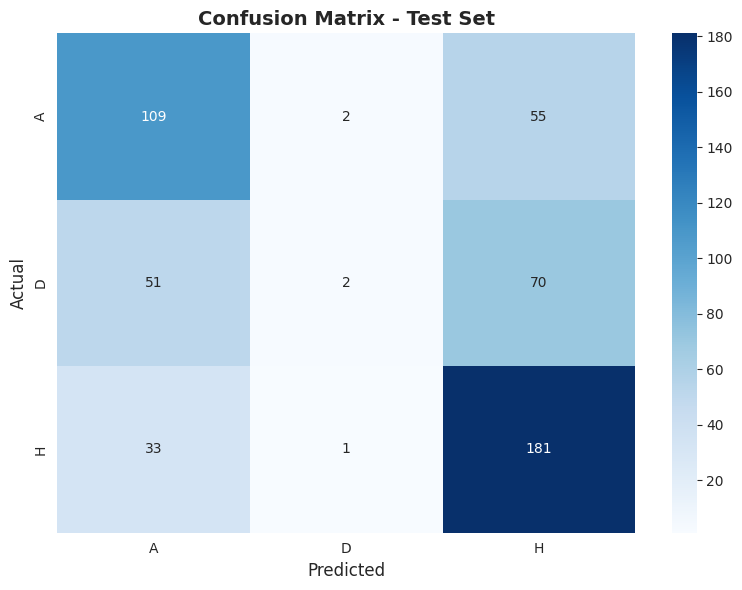


Plotting training history...


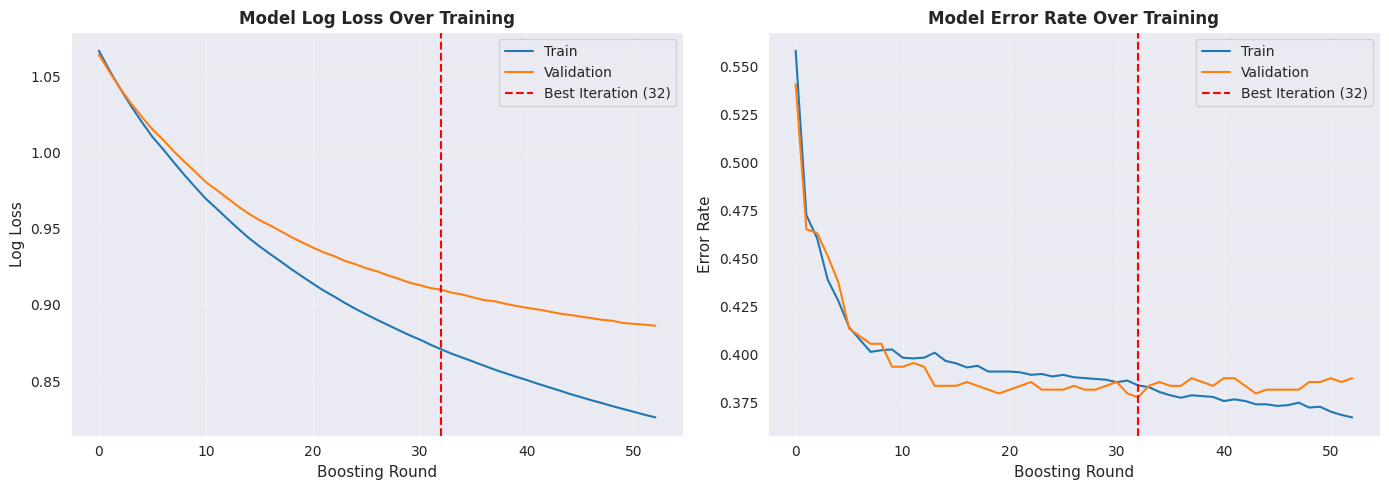


✓ Model evaluation complete!

✓ Model artifacts stored in 'model_artifacts' dictionary


In [7]:
# Step 5: XGBoost Model Training & Hyperparameter Tuning

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import log_loss, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("XGBOOST MODEL TRAINING")
print("=" * 60)

# First, let's train a baseline model with default parameters
print("\n[1] BASELINE MODEL (Default Parameters)")
print("-" * 60)

# Create DMatrix for XGBoost (more efficient)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Baseline parameters
baseline_params = {
    'objective': 'multi:softprob',  # Multi-class classification with probabilities
    'num_class': 3,  # H, D, A
    'eval_metric': ['mlogloss', 'merror'],  # Log loss and error rate
    'seed': 42,
    'tree_method': 'hist',  # Faster training
}

# Train baseline model
print("\nTraining baseline model...")
evals = [(dtrain, 'train'), (dval, 'validation')]
evals_result_baseline = {}

baseline_model = xgb.train(
    baseline_params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    evals_result=evals_result_baseline,
    verbose_eval=20
)

# Evaluate baseline
y_pred_baseline = baseline_model.predict(dval)
y_pred_baseline_labels = np.argmax(y_pred_baseline, axis=1)

baseline_accuracy = accuracy_score(y_val, y_pred_baseline_labels)
baseline_logloss = log_loss(y_val, y_pred_baseline)

print(f"\n✓ Baseline Validation Accuracy: {baseline_accuracy:.4f}")
print(f"✓ Baseline Validation Log Loss: {baseline_logloss:.4f}")

# Now let's tune hyperparameters
print("\n" + "=" * 60)
print("[2] HYPERPARAMETER TUNING")
print("=" * 60)

from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3],    # L2 regularization
}

print("\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Create XGBoost classifier for sklearn compatibility
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    seed=42,
    tree_method='hist',
    early_stopping_rounds=20,
)

print(f"\nPerforming Randomized Search with 20 iterations...")
print("This may take a few minutes...\n")

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter combinations to try
    scoring='neg_log_loss',  # Use log loss as metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit on training data
random_search.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("\n✓ Hyperparameter tuning complete!")

# Best parameters
print("\n" + "=" * 60)
print("BEST PARAMETERS")
print("=" * 60)
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score (neg_log_loss): {random_search.best_score_:.4f}")

# Train final model with best parameters
print("\n" + "=" * 60)
print("[3] FINAL MODEL TRAINING")
print("=" * 60)

best_params = random_search.best_params_.copy()

# Convert sklearn params to xgboost params
final_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'min_child_weight': best_params['min_child_weight'],
    'gamma': best_params['gamma'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'seed': 42,
    'tree_method': 'hist',
}

print("\nTraining final model with best parameters...")
print(f"Number of boosting rounds: {best_params['n_estimators']}")

evals_result_final = {}
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=evals,
    evals_result=evals_result_final,
    verbose_eval=50,
    early_stopping_rounds=20
)

print("\n✓ Final model training complete!")

# Save the best iteration
best_iteration = final_model.best_iteration
print(f"\nBest iteration: {best_iteration}")

print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Predictions on all sets
y_train_pred = final_model.predict(dtrain)
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

y_val_pred = final_model.predict(dval)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)

y_test_pred = final_model.predict(dtest)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
val_accuracy = accuracy_score(y_val, y_val_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

train_logloss = log_loss(y_train, y_train_pred)
val_logloss = log_loss(y_val, y_val_pred)
test_logloss = log_loss(y_test, y_test_pred)

print("\n[ACCURACY SCORES]")
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy:       {test_accuracy:.4f}")

print("\n[LOG LOSS SCORES]")
print(f"Training Log Loss:   {train_logloss:.4f}")
print(f"Validation Log Loss: {val_logloss:.4f}")
print(f"Test Log Loss:       {test_logloss:.4f}")

print("\n[F1 SCORES]")
train_f1 = f1_score(y_train, y_train_pred_labels, average='weighted')
val_f1 = f1_score(y_val, y_val_pred_labels, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_labels, average='weighted')

print(f"Training F1 (weighted):   {train_f1:.4f}")
print(f"Validation F1 (weighted): {val_f1:.4f}")
print(f"Test F1 (weighted):       {test_f1:.4f}")

# Detailed classification report for test set
print("\n" + "=" * 60)
print("DETAILED TEST SET CLASSIFICATION REPORT")
print("=" * 60)

print("\n", classification_report(
    y_test,
    y_test_pred_labels,
    target_names=le.classes_,
    digits=4
))

# Confusion Matrix
print("\n" + "=" * 60)
print("CONFUSION MATRIX (Test Set)")
print("=" * 60)

cm = confusion_matrix(y_test, y_test_pred_labels)
print("\nConfusion Matrix:")
print(f"{'':10} {'Pred A':>10} {'Pred D':>10} {'Pred H':>10}")
print(f"{'Actual A':10} {cm[0,0]:10} {cm[0,1]:10} {cm[0,2]:10}")
print(f"{'Actual D':10} {cm[1,0]:10} {cm[1,1]:10} {cm[1,2]:10}")
print(f"{'Actual H':10} {cm[2,0]:10} {cm[2,1]:10} {cm[2,2]:10}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Plot training history
print("\nPlotting training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot log loss
epochs = range(len(evals_result_final['train']['mlogloss']))
ax1.plot(epochs, evals_result_final['train']['mlogloss'], label='Train')
ax1.plot(epochs, evals_result_final['validation']['mlogloss'], label='Validation')
ax1.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best Iteration ({best_iteration})')
ax1.set_xlabel('Boosting Round', fontsize=11)
ax1.set_ylabel('Log Loss', fontsize=11)
ax1.set_title('Model Log Loss Over Training', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot error rate
ax2.plot(epochs, evals_result_final['train']['merror'], label='Train')
ax2.plot(epochs, evals_result_final['validation']['merror'], label='Validation')
ax2.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best Iteration ({best_iteration})')
ax2.set_xlabel('Boosting Round', fontsize=11)
ax2.set_ylabel('Error Rate', fontsize=11)
ax2.set_title('Model Error Rate Over Training', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Model evaluation complete!")

# Store final model and results
model_artifacts = {
    'final_model': final_model,
    'best_params': best_params,
    'label_encoder': le,
    'feature_columns': feature_columns,
    'test_accuracy': test_accuracy,
    'test_logloss': test_logloss,
    'test_f1': test_f1,
    'confusion_matrix': cm,
    'best_iteration': best_iteration
}

print("\n✓ Model artifacts stored in 'model_artifacts' dictionary")

## Step 6: Feature Importance Analysis & Model Interpretation

FEATURE IMPORTANCE ANALYSIS

[1] Extracting Feature Importance...
Features in importance_dict: 43
Feature columns available: 44
✓ Extracted importance for 43 features

TOP 20 MOST IMPORTANT FEATURES
                Feature  Importance
                    HST       201.0
                    AST       175.0
                     HC        82.0
         PPG_Difference        79.0
Away_avg_goals_conceded        43.0
     WinRate_Difference        41.0
    Away_matches_played        36.0
Home_avg_goals_conceded        33.0
  Home_avg_goals_scored        30.0
                     AC        29.0
                     HS        26.0
  Away_avg_goals_scored        25.0
            MatchNumber        24.0
                     HY        23.0
                     HF        20.0
          Away_win_rate        19.0
                     AF        15.0
        Form_Difference        13.0
     Home_points_last_5        13.0
          Home_win_rate        13.0

[2] Visualizing Feature Importance...


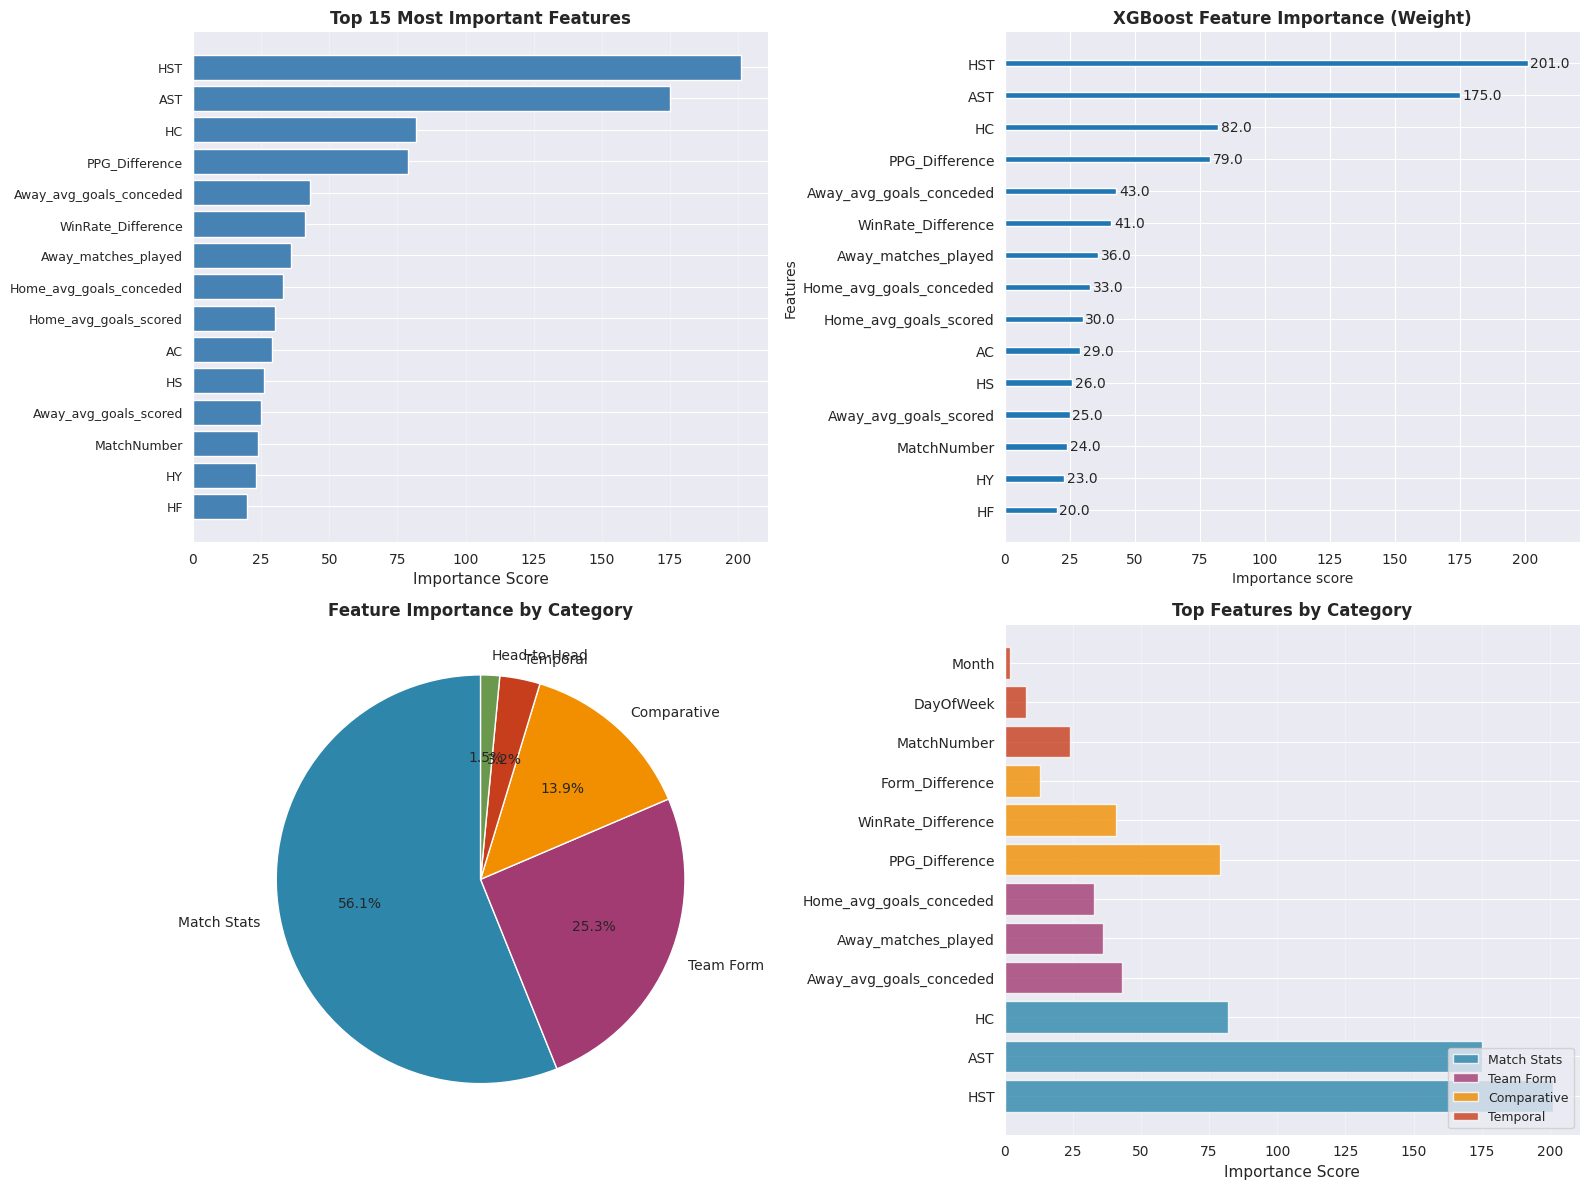

✓ Feature importance visualizations created

FEATURE IMPORTANCE BY CATEGORY

Match Stats:
  Total Features: 12
  Total Importance: 598
  Average per Feature: 49.8
  Percentage of Total: 56.1%
  Top features:
    - HST: 201
    - AST: 175
    - HC: 82

Team Form:
  Total Features: 18
  Total Importance: 270
  Average per Feature: 15.0
  Percentage of Total: 25.3%
  Top features:
    - Away_avg_goals_conceded: 43
    - Away_matches_played: 36
    - Home_avg_goals_conceded: 33

Comparative:
  Total Features: 5
  Total Importance: 148
  Average per Feature: 29.6
  Percentage of Total: 13.9%
  Top features:
    - PPG_Difference: 79
    - WinRate_Difference: 41
    - Form_Difference: 13

Temporal:
  Total Features: 3
  Total Importance: 34
  Average per Feature: 11.3
  Percentage of Total: 3.2%
  Top features:
    - MatchNumber: 24
    - DayOfWeek: 8
    - Month: 2

Head-to-Head:
  Total Features: 5
  Total Importance: 16
  Average per Feature: 3.2
  Percentage of Total: 1.5%
  Top features:

In [8]:
# Step 6: Feature Importance Analysis & Model Interpretation (FIXED)

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance using the built-in method
print("\n[1] Extracting Feature Importance...")

# Get importance as arrays directly from the booster
importance_dict = final_model.get_score(importance_type='weight')
importance_gain = final_model.get_score(importance_type='gain')
importance_cover = final_model.get_score(importance_type='cover')

print(f"Features in importance_dict: {len(importance_dict)}")
print(f"Feature columns available: {len(feature_columns)}")

# Check if we have importance scores
if len(importance_dict) == 0:
    print("\nUsing alternative method to extract feature importance...")

    # Get importance using plot_importance data
    import matplotlib.pyplot as plt

    # Method 2: Use get_fscore (deprecated but works)
    try:
        importance_dict = final_model.get_fscore()
    except:
        pass

    # Method 3: Extract from booster trees
    if len(importance_dict) == 0:
        # Create importance from scratch using feature names
        fig, ax = plt.subplots(figsize=(1, 1))
        xgb.plot_importance(final_model, ax=ax, importance_type='weight', max_num_features=50)

        # Extract data from the plot
        importance_data = {}
        for i, (label, value) in enumerate(zip(ax.get_yticklabels(), ax.get_children()[0].get_widths())):
            feat_name = label.get_text()
            importance_data[feat_name] = value

        plt.close(fig)
        importance_dict = importance_data

# If still empty, create manually
if len(importance_dict) == 0:
    print("Creating feature importance from model structure...")

    # Alternative: create importance based on feature positions
    feature_importance = {}

    # Get the booster and extract tree structure
    trees_df = final_model.trees_to_dataframe()

    # Count feature usage
    if 'Feature' in trees_df.columns:
        feature_counts = trees_df[trees_df['Feature'] != 'Leaf']['Feature'].value_counts()

        # Map back to original feature names
        for feat_id, count in feature_counts.items():
            if feat_id.startswith('f'):
                idx = int(feat_id[1:])
                if idx < len(feature_columns):
                    feature_importance[feature_columns[idx]] = count
            else:
                feature_importance[feat_id] = count

        importance_dict = feature_importance

print(f"✓ Extracted importance for {len(importance_dict)} features")

# Create DataFrame
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# If feature names are still f0, f1, etc., map them
if importance_df['Feature'].iloc[0].startswith('f'):
    def map_feature_name(feat):
        if feat.startswith('f'):
            idx = int(feat[1:])
            if idx < len(feature_columns):
                return feature_columns[idx]
        return feat

    importance_df['Feature'] = importance_df['Feature'].apply(map_feature_name)

print("\n" + "=" * 60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

# Visualize feature importance
print("\n[2] Visualizing Feature Importance...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 15 features
top_n = 15
top_features = importance_df.head(top_n)

axes[0, 0].barh(range(len(top_features)), top_features['Importance'], color='steelblue')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['Feature'], fontsize=9)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance Score', fontsize=11)
axes[0, 0].set_title(f'Top {top_n} Most Important Features', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: XGBoost built-in plot
xgb.plot_importance(final_model, ax=axes[0, 1], max_num_features=15,
                     importance_type='weight', show_values=True)
axes[0, 1].set_title('XGBoost Feature Importance (Weight)', fontsize=12, fontweight='bold')

# Plot 3: Feature categories
def categorize_feature(feat):
    if 'H2H' in feat:
        return 'Head-to-Head'
    elif 'Home_' in feat or 'Away_' in feat:
        return 'Team Form'
    elif 'Difference' in feat:
        return 'Comparative'
    elif feat in ['Month', 'DayOfWeek', 'MatchNumber']:
        return 'Temporal'
    elif feat in ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']:
        return 'Match Stats'
    else:
        return 'Other'

importance_df['Category'] = importance_df['Feature'].apply(categorize_feature)
category_importance = importance_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)

colors_cat = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']
axes[1, 0].pie(category_importance.values, labels=category_importance.index, autopct='%1.1f%%',
               startangle=90, colors=colors_cat[:len(category_importance)])
axes[1, 0].set_title('Feature Importance by Category', fontsize=12, fontweight='bold')

# Plot 4: Top features by category
top_features_per_category = importance_df.groupby('Category').head(3)
category_colors = dict(zip(category_importance.index, colors_cat[:len(category_importance)]))

for cat in category_importance.index[:4]:  # Top 4 categories
    cat_features = top_features_per_category[top_features_per_category['Category'] == cat]
    if len(cat_features) > 0:
        axes[1, 1].barh(cat_features['Feature'], cat_features['Importance'],
                        label=cat, alpha=0.8, color=category_colors[cat])

axes[1, 1].set_xlabel('Importance Score', fontsize=11)
axes[1, 1].set_title('Top Features by Category', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='lower right', fontsize=9)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Feature importance visualizations created")

# Category analysis
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE BY CATEGORY")
print("=" * 60)

for category, total_imp in category_importance.items():
    count = len(importance_df[importance_df['Category'] == category])
    avg_imp = total_imp / count if count > 0 else 0
    pct = (total_imp / importance_df['Importance'].sum()) * 100
    print(f"\n{category}:")
    print(f"  Total Features: {count}")
    print(f"  Total Importance: {total_imp:.0f}")
    print(f"  Average per Feature: {avg_imp:.1f}")
    print(f"  Percentage of Total: {pct:.1f}%")

    # Show top 3 features in this category
    top_cat_features = importance_df[importance_df['Category'] == category].head(3)
    print(f"  Top features:")
    for idx, row in top_cat_features.iterrows():
        print(f"    - {row['Feature']}: {row['Importance']:.0f}")

# Continue with prediction analysis
print("\n" + "=" * 60)
print("PREDICTION ANALYSIS")
print("=" * 60)

# Analyze predictions
test_match_info = df_model.iloc[val_end:].copy()
test_match_info['Pred_A'] = y_test_pred[:, 0]
test_match_info['Pred_D'] = y_test_pred[:, 1]
test_match_info['Pred_H'] = y_test_pred[:, 2]
test_match_info['Predicted_Result'] = le.inverse_transform(y_test_pred_labels)
test_match_info['Actual_Result'] = le.inverse_transform(y_test)
test_match_info['Correct'] = (test_match_info['Predicted_Result'] == test_match_info['Actual_Result'])
test_match_info['Max_Probability'] = test_match_info[['Pred_A', 'Pred_D', 'Pred_H']].max(axis=1)

print("\n[Prediction Confidence Analysis]")
confidence_bins = [0, 0.4, 0.5, 0.6, 0.7, 1.0]
confidence_labels = ['Very Low (<0.4)', 'Low (0.4-0.5)', 'Medium (0.5-0.6)', 'High (0.6-0.7)', 'Very High (>0.7)']

test_match_info['Confidence_Bin'] = pd.cut(test_match_info['Max_Probability'],
                                             bins=confidence_bins,
                                             labels=confidence_labels)

confidence_analysis = test_match_info.groupby('Confidence_Bin', observed=True).agg({
    'Correct': ['count', 'sum', lambda x: f"{x.mean()*100:.1f}%"]
})
confidence_analysis.columns = ['Total Predictions', 'Correct', 'Accuracy']
print(confidence_analysis)

print("\n[Accuracy by Predicted Outcome]")
outcome_analysis = test_match_info.groupby('Predicted_Result').agg({
    'Correct': ['count', 'sum', lambda x: f"{x.mean()*100:.1f}%"]
})
outcome_analysis.columns = ['Total Predictions', 'Correct', 'Accuracy']
print(outcome_analysis)

print("\n✓ Feature importance analysis complete!")

# Store results
analysis_results = {
    'importance_df': importance_df,
    'category_importance': category_importance,
    'test_match_info': test_match_info,
}

print("\n✓ Analysis results stored in 'analysis_results' dictionary")

In [19]:
df.to_csv('data/epl_cleaned.csv', index=False)

## Step 7: Model Saving and Making Predictions on New Data

In [9]:
# Step 7: Model Saving and Making Predictions on New Data

import pickle
import json
from datetime import datetime

print("=" * 60)
print("MODEL SAVING & DEPLOYMENT PREPARATION")
print("=" * 60)

# Save the XGBoost model
print("\n[1] Saving XGBoost Model...")

model_filename = 'epl_xgboost_model.json'
final_model.save_model(model_filename)
print(f"✓ Model saved to: {model_filename}")

# Save additional artifacts (label encoder, feature columns, etc.)
print("\n[2] Saving Model Artifacts...")

artifacts = {
    'label_encoder': le,
    'feature_columns': feature_columns,
    'best_params': best_params,
    'test_accuracy': test_accuracy,
    'test_logloss': test_logloss,
    'best_iteration': best_iteration,
    'feature_importance': importance_df.to_dict('records'),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_version': '1.0',
    'train_date_range': f"{train_dates.min().date()} to {train_dates.max().date()}",
    'test_date_range': f"{test_dates.min().date()} to {test_dates.max().date()}",
}

artifacts_filename = 'model_artifacts.pkl'
with open(artifacts_filename, 'wb') as f:
    pickle.dump(artifacts, f)

print(f"✓ Artifacts saved to: {artifacts_filename}")

# Save a JSON version for easy reading
json_artifacts = {
    'best_params': best_params,
    'test_accuracy': float(test_accuracy),
    'test_logloss': float(test_logloss),
    'best_iteration': int(best_iteration),
    'training_date': artifacts['training_date'],
    'model_version': artifacts['model_version'],
    'train_date_range': artifacts['train_date_range'],
    'test_date_range': artifacts['test_date_range'],
    'feature_columns': feature_columns,
    'top_10_features': importance_df.head(10)['Feature'].tolist(),
}

json_filename = 'model_info.json'
with open(json_filename, 'w') as f:
    json.dump(json_artifacts, f, indent=4)

print(f"✓ Model info saved to: {json_filename}")

print("\n" + "=" * 60)
print("CREATING PREDICTION FUNCTION")
print("=" * 60)

def load_model_and_predict(match_data_df):
    """
    Load the saved model and make predictions on new match data

    Parameters:
    -----------
    match_data_df : DataFrame
        DataFrame with the same features as training data
        Must include all feature columns

    Returns:
    --------
    predictions_df : DataFrame
        DataFrame with predictions and probabilities
    """
    # Load model
    loaded_model = xgb.Booster()
    loaded_model.load_model(model_filename)

    # Load artifacts
    with open(artifacts_filename, 'rb') as f:
        loaded_artifacts = pickle.load(f)

    le_loaded = loaded_artifacts['label_encoder']
    features_loaded = loaded_artifacts['feature_columns']

    # Prepare features
    X_new = match_data_df[features_loaded].fillna(0)

    # Make predictions
    dmatrix_new = xgb.DMatrix(X_new)
    predictions_proba = loaded_model.predict(dmatrix_new)
    predictions_labels = np.argmax(predictions_proba, axis=1)
    predictions_class = le_loaded.inverse_transform(predictions_labels)

    # Create results dataframe
    results = pd.DataFrame({
        'Predicted_Result': predictions_class,
        'Prob_Away': predictions_proba[:, 0],
        'Prob_Draw': predictions_proba[:, 1],
        'Prob_Home': predictions_proba[:, 2],
        'Confidence': predictions_proba.max(axis=1)
    })

    return results

print("✓ Prediction function created: load_model_and_predict()")

print("\n" + "=" * 60)
print("TESTING PREDICTION FUNCTION")
print("=" * 60)

# Test on a sample from test set
print("\nTesting on 5 random matches from test set...")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_matches = df_model.iloc[val_end:].iloc[sample_indices]

# Prepare sample data
sample_X = sample_matches[feature_columns].fillna(0)

# Make predictions using our function
predictions = load_model_and_predict(sample_X)

# Display results
print("\nPrediction Results:")
print("-" * 100)

for i, (idx, match) in enumerate(sample_matches.iterrows()):
    print(f"\nMatch {i+1}: {match['Date'].date()} | {match['HomeTeam']} vs {match['AwayTeam']}")
    print(f"  Actual Result: {match['FTR']} (Score: {int(match['FTHG'])}-{int(match['FTAG'])})")
    print(f"  Predicted Result: {predictions.iloc[i]['Predicted_Result']}")
    print(f"  Probabilities - Home: {predictions.iloc[i]['Prob_Home']:.3f}, "
          f"Draw: {predictions.iloc[i]['Prob_Draw']:.3f}, Away: {predictions.iloc[i]['Prob_Away']:.3f}")
    print(f"  Confidence: {predictions.iloc[i]['Confidence']:.3f}")

    # Show key features for this match
    key_features = importance_df.head(5)['Feature'].tolist()
    print(f"  Key Feature Values:")
    for feat in key_features:
        if feat in sample_X.columns:
            print(f"    {feat}: {sample_X.iloc[i][feat]:.2f}")

print("\n✓ Prediction function tested successfully!")

print("\n" + "=" * 60)
print("CREATING PREDICTION PIPELINE FOR UPCOMING MATCHES")
print("=" * 60)

def predict_upcoming_match(home_team, away_team, historical_data):
    """
    Predict outcome for an upcoming match

    Parameters:
    -----------
    home_team : str
        Name of home team
    away_team : str
        Name of away team
    historical_data : DataFrame
        Historical match data (df_features from our training)

    Returns:
    --------
    prediction_dict : dict
        Dictionary with prediction and key statistics
    """
    from datetime import datetime, timedelta

    # Use current date or most recent date in data
    match_date = historical_data['Date'].max() + timedelta(days=7)

    # Calculate form for both teams
    def get_team_form(team, is_home, hist_data, ref_date):
        # Get team's previous matches
        prev_home = hist_data[(hist_data['HomeTeam'] == team) & (hist_data['Date'] < ref_date)]
        prev_away = hist_data[(hist_data['AwayTeam'] == team) & (hist_data['Date'] < ref_date)]

        prev_matches = pd.concat([prev_home, prev_away]).sort_values('Date')

        if len(prev_matches) < 3:
            return None  # Not enough data

        # Last 5 matches
        last_5 = prev_matches.tail(5)

        goals_scored_5 = 0
        goals_conceded_5 = 0
        points_5 = 0
        wins_5 = 0

        for _, match in last_5.iterrows():
            if match['HomeTeam'] == team:
                goals_scored_5 += match['FTHG']
                goals_conceded_5 += match['FTAG']
                points_5 += match['HomePoints']
                wins_5 += 1 if match['FTR'] == 'H' else 0
            else:
                goals_scored_5 += match['FTAG']
                goals_conceded_5 += match['FTHG']
                points_5 += match['AwayPoints']
                wins_5 += 1 if match['FTR'] == 'A' else 0

        # Overall stats
        total_goals_scored = 0
        total_goals_conceded = 0
        total_points = 0
        total_wins = 0

        for _, match in prev_matches.iterrows():
            if match['HomeTeam'] == team:
                total_goals_scored += match['FTHG']
                total_goals_conceded += match['FTAG']
                total_points += match['HomePoints']
                total_wins += 1 if match['FTR'] == 'H' else 0
            else:
                total_goals_scored += match['FTAG']
                total_goals_conceded += match['FTHG']
                total_points += match['AwayPoints']
                total_wins += 1 if match['FTR'] == 'A' else 0

        matches_played = len(prev_matches)

        return {
            'matches_played': matches_played,
            'points_last_5': points_5,
            'goals_scored_last_5': goals_scored_5,
            'goals_conceded_last_5': goals_conceded_5,
            'wins_last_5': wins_5,
            'avg_goals_scored': total_goals_scored / matches_played,
            'avg_goals_conceded': total_goals_conceded / matches_played,
            'win_rate': total_wins / matches_played,
            'points_per_game': total_points / matches_played,
        }

    # Get form for both teams
    home_form = get_team_form(home_team, True, historical_data, match_date)
    away_form = get_team_form(away_team, False, historical_data, match_date)

    if home_form is None or away_form is None:
        return {"error": "Insufficient historical data for one or both teams"}

    # Calculate H2H
    prev_h2h = historical_data[
        (((historical_data['HomeTeam'] == home_team) & (historical_data['AwayTeam'] == away_team)) |
         ((historical_data['HomeTeam'] == away_team) & (historical_data['AwayTeam'] == home_team))) &
        (historical_data['Date'] < match_date)
    ].tail(5)

    if len(prev_h2h) > 0:
        h2h_home_wins = 0
        h2h_draws = 0
        h2h_away_wins = 0
        h2h_home_goals = 0
        h2h_away_goals = 0

        for _, match in prev_h2h.iterrows():
            if match['HomeTeam'] == home_team:
                h2h_home_goals += match['FTHG']
                h2h_away_goals += match['FTAG']
                if match['FTR'] == 'H':
                    h2h_home_wins += 1
                elif match['FTR'] == 'D':
                    h2h_draws += 1
                else:
                    h2h_away_wins += 1
            else:
                h2h_home_goals += match['FTAG']
                h2h_away_goals += match['FTHG']
                if match['FTR'] == 'A':
                    h2h_home_wins += 1
                elif match['FTR'] == 'D':
                    h2h_draws += 1
                else:
                    h2h_away_wins += 1

        h2h_data = {
            'H2H_matches': len(prev_h2h),
            'H2H_home_wins': h2h_home_wins,
            'H2H_draws': h2h_draws,
            'H2H_away_wins': h2h_away_wins,
            'H2H_home_goals': h2h_home_goals / len(prev_h2h),
            'H2H_away_goals': h2h_away_goals / len(prev_h2h),
        }
    else:
        h2h_data = {
            'H2H_matches': 0,
            'H2H_home_wins': 0,
            'H2H_draws': 0,
            'H2H_away_wins': 0,
            'H2H_home_goals': 0,
            'H2H_away_goals': 0,
        }

    # Create feature dictionary
    features = {}

    # Add home team features
    for key, value in home_form.items():
        features[f'Home_{key}'] = value

    # Add away team features
    for key, value in away_form.items():
        features[f'Away_{key}'] = value

    # Add H2H features
    features.update(h2h_data)

    # Add comparative features
    features['Form_Difference'] = home_form['points_last_5'] - away_form['points_last_5']
    features['GoalScoring_Difference'] = home_form['goals_scored_last_5'] - away_form['goals_scored_last_5']
    features['Defense_Difference'] = away_form['goals_conceded_last_5'] - home_form['goals_conceded_last_5']
    features['WinRate_Difference'] = home_form['win_rate'] - away_form['win_rate']
    features['PPG_Difference'] = home_form['points_per_game'] - away_form['points_per_game']

    # Add time features
    features['Month'] = match_date.month
    features['DayOfWeek'] = match_date.dayofweek
    features['MatchNumber'] = 20  # Mid-season estimate

    # Add any missing features with 0
    for col in feature_columns:
        if col not in features:
            features[col] = 0

    # Create DataFrame
    features_df = pd.DataFrame([features])[feature_columns]

    # Make prediction
    prediction = load_model_and_predict(features_df)

    return {
        'home_team': home_team,
        'away_team': away_team,
        'predicted_result': prediction.iloc[0]['Predicted_Result'],
        'prob_home': float(prediction.iloc[0]['Prob_Home']),
        'prob_draw': float(prediction.iloc[0]['Prob_Draw']),
        'prob_away': float(prediction.iloc[0]['Prob_Away']),
        'confidence': float(prediction.iloc[0]['Confidence']),
        'home_form': home_form,
        'away_form': away_form,
        'h2h': h2h_data,
    }

print("✓ Prediction pipeline created: predict_upcoming_match()")

print("\n" + "=" * 60)
print("TESTING UPCOMING MATCH PREDICTION")
print("=" * 60)

# Test with some teams from our dataset
teams = df_model['HomeTeam'].unique()
test_home = teams[0]
test_away = teams[1]

print(f"\nPredicting: {test_home} vs {test_away}")
print("-" * 60)

result = predict_upcoming_match(test_home, test_away, df_features)

if 'error' in result:
    print(f"Error: {result['error']}")
else:
    print(f"\nPredicted Winner: {result['predicted_result']}")
    print(f"Confidence: {result['confidence']:.1%}")
    print(f"\nProbabilities:")
    print(f"  Home Win ({test_home}): {result['prob_home']:.1%}")
    print(f"  Draw: {result['prob_draw']:.1%}")
    print(f"  Away Win ({test_away}): {result['prob_away']:.1%}")

    print(f"\nHome Team Form (Last 5):")
    print(f"  Points: {result['home_form']['points_last_5']}")
    print(f"  Goals Scored: {result['home_form']['goals_scored_last_5']}")
    print(f"  Goals Conceded: {result['home_form']['goals_conceded_last_5']}")

    print(f"\nAway Team Form (Last 5):")
    print(f"  Points: {result['away_form']['points_last_5']}")
    print(f"  Goals Scored: {result['away_form']['goals_scored_last_5']}")
    print(f"  Goals Conceded: {result['away_form']['goals_conceded_last_5']}")

    print(f"\nHead-to-Head (Last {result['h2h']['H2H_matches']} matches):")
    print(f"  Home Wins: {result['h2h']['H2H_home_wins']}")
    print(f"  Draws: {result['h2h']['H2H_draws']}")
    print(f"  Away Wins: {result['h2h']['H2H_away_wins']}")

print("\n" + "=" * 60)
print("MODEL DEPLOYMENT READY!")
print("=" * 60)

print(f"""
✓ Model saved and ready for deployment!

Files created:
1. {model_filename} - XGBoost model
2. {artifacts_filename} - Model artifacts (label encoder, features, etc.)
3. {json_filename} - Model metadata (JSON)

Functions available:
1. load_model_and_predict(match_data_df) - Predict on prepared data
2. predict_upcoming_match(home_team, away_team, historical_data) - Predict any match

Model Performance:
- Test Accuracy: {test_accuracy:.2%}
- Test Log Loss: {test_logloss:.4f}
- Test F1 Score: {test_f1:.4f}

The model is ready to make predictions on new Premier League matches!
""")

MODEL SAVING & DEPLOYMENT PREPARATION

[1] Saving XGBoost Model...
✓ Model saved to: epl_xgboost_model.json

[2] Saving Model Artifacts...
✓ Artifacts saved to: model_artifacts.pkl
✓ Model info saved to: model_info.json

CREATING PREDICTION FUNCTION
✓ Prediction function created: load_model_and_predict()

TESTING PREDICTION FUNCTION

Testing on 5 random matches from test set...

Prediction Results:
----------------------------------------------------------------------------------------------------

Match 1: 2024-05-04 | Brentford vs Fulham
  Actual Result: D (Score: 0-0)
  Predicted Result: H
  Probabilities - Home: 0.427, Draw: 0.298, Away: 0.275
  Confidence: 0.427
  Key Feature Values:
    HST: 3.00
    AST: 3.00
    HC: 7.00
    PPG_Difference: 0.26
    Away_avg_goals_conceded: 1.62

Match 2: 2024-08-24 | Tottenham vs Everton
  Actual Result: H (Score: 4-0)
  Predicted Result: H
  Probabilities - Home: 0.600, Draw: 0.300, Away: 0.099
  Confidence: 0.600
  Key Feature Values:
    HS